In [1]:
import os
print(os.getcwd())
rdir='/home/hyeryungson'
os.chdir(os.path.join(rdir, 'mucoco/notebooks'))
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch
from torch.nn import Softmax
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import DataCollatorWithPadding

from utils.load_ckpt import define_model

import json
import argparse
import time
from itertools import chain
from tqdm import tqdm


/home/hyeryungson/mucoco


In [2]:
os.chdir(os.path.join(rdir, 'mucoco'))

In [3]:
# set gpu (template code)
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  # Set the GPU 0 to use

In [4]:
BATCH_SIZE=64
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Which cpu/cuda?: {DEVICE}")
print(f"Which device?: {torch.cuda.current_device()}")

Which cpu/cuda?: cuda
Which device?: 0


In [5]:
# define dataset, dataloader
toxicity_data = load_dataset("csv", data_files="./notebooks/results/test_mucoco+add_preds2.csv")

Found cached dataset csv (/home/hyeryungson/.cache/huggingface/datasets/csv/default-f2c97d4747e75281/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
# load trained model
# checkpoint='./models_bak_contd/roberta-base-jigsaw-toxicity-classifier-with-gpt2-large-embeds/checkpoint_best/pytorch_model.bin' # binary
# checkpoint='./models_230507/roberta-base-jigsaw-toxicity-classifier-with-gpt2-large-embeds/checkpoint_best/pytorch_model.bin' # balanced
checkpoint='/home/hyeryungson/mucoco/models/roberta-base-jigsaw-toxicity-classifier-with-gpt2-large-embeds/checkpoint_best/pytorch_model.bin' # addmore
model, config, tokenizer = define_model(checkpoint, output_attentions=True)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializin

DEVICE:  cuda


In [7]:
# 논문에서는 gpt-2의 tokenizer를 사용하였으므로, mask token이 기존에는 없었음
print(tokenizer.all_special_ids, tokenizer.all_special_tokens, tokenizer.vocab_size)

# tokenizer에 mask token 추가
print('add mask token')
SPECIAL_TOKENS = {"mask_token": "<mask>"}
tokenizer.add_special_tokens(SPECIAL_TOKENS)

print(tokenizer.all_special_ids, tokenizer.all_special_tokens, tokenizer.vocab_size)

[50256] ['<|endoftext|>'] 50257
add mask token
[50256, 50257] ['<|endoftext|>', '<mask>'] 50257


In [8]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

tokenized_dataset=toxicity_data.map(tokenize_function, batched=True)

Loading cached processed dataset at /home/hyeryungson/.cache/huggingface/datasets/csv/default-f2c97d4747e75281/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-ae5847428c8ea7f5.arrow


In [9]:
# remove unnecessary columns
tokenized_dataset = tokenized_dataset.remove_columns(["text", 'pred_binarize', 'pred_balanced', 'pred_add', 'pred_addmore', 'pred_binary'])
tokenized_dataset = tokenized_dataset.rename_column("toxicity", "labels")
tokenized_dataset.set_format("torch")
tokenized_dataset["train"].column_names

['labels', 'input_ids', 'attention_mask']

In [10]:
# tokenized_dataset_subset = tokenized_dataset["train"].filter(lambda x: (x["labels"]>=0.9) and (x["labels"]<1.0))
tokenized_dataset_subset = tokenized_dataset["train"].filter(lambda x: (x["labels"]==1.0))

Loading cached processed dataset at /home/hyeryungson/.cache/huggingface/datasets/csv/default-f2c97d4747e75281/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-d02cbf92137c12b1.arrow


In [11]:
# build data loader
batch_size = 32
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
subset_dataloader = DataLoader(
    dataset=tokenized_dataset_subset, shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

In [12]:
layer_num=10
cls_attns_soft_list = []
input_id_list = []
labels_list = []
preds_list = []
model.eval()
for batch in subset_dataloader:
    batch = {k: v.to(DEVICE) for k, v in batch.items()} # move training data to gpu
    with torch.no_grad():
        outputs = model.forward(
            batch["input_ids"],
            attention_mask=batch["attention_mask"],
        )
    attentions = outputs["attentions"][layer_num]
    cls_attns = attentions.max(1)[0][:, 0]
    cls_attns[cls_attns==0.0] = -float("inf")
    cls_attns_soft = cls_attns.softmax(-1)
    cls_attns_soft_list.append(cls_attns_soft)
    input_id_list.append(batch["input_ids"])
    labels_list.append(batch["labels"])
    preds_list.append(outputs["logits"].softmax(-1)[:,1])

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Batch:  0


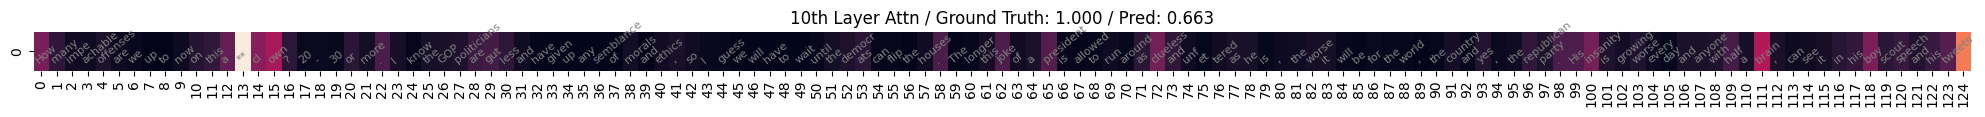

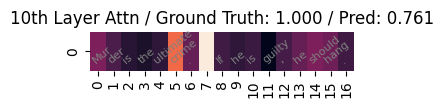

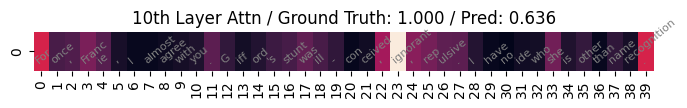

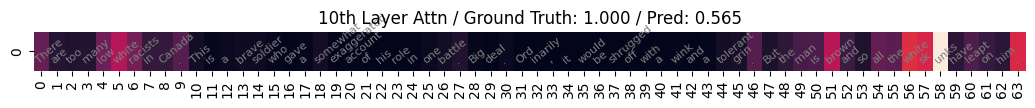

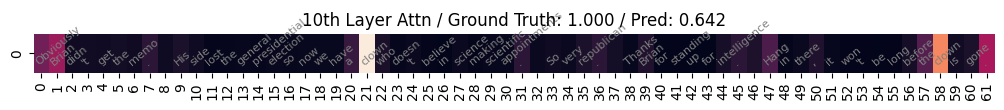

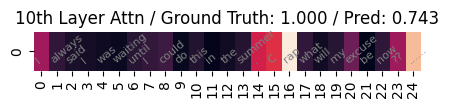

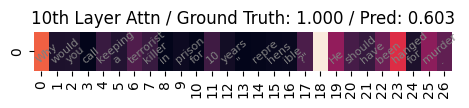

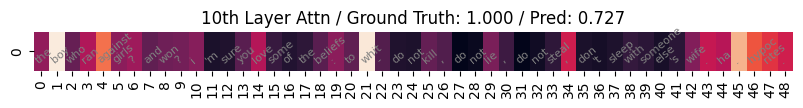

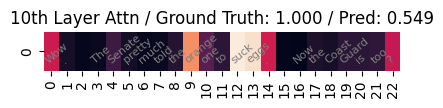

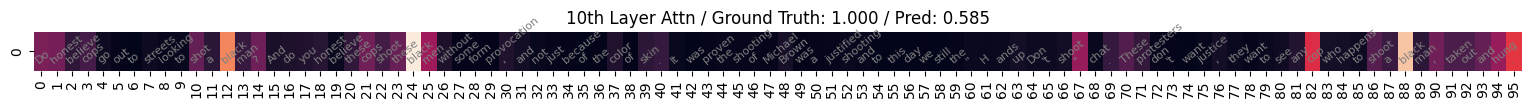

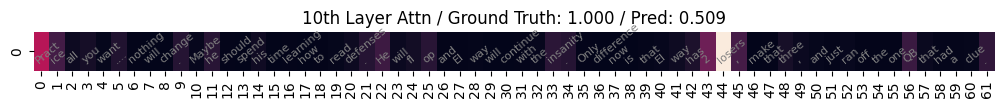

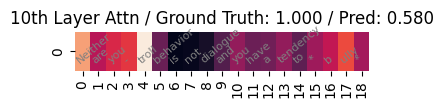

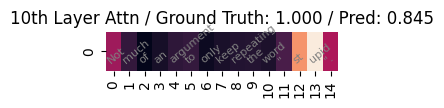

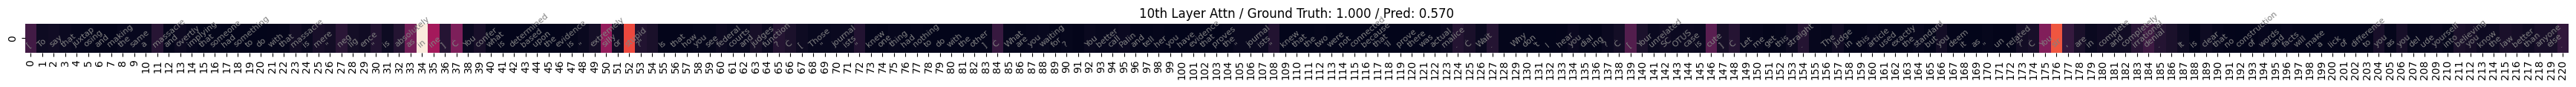

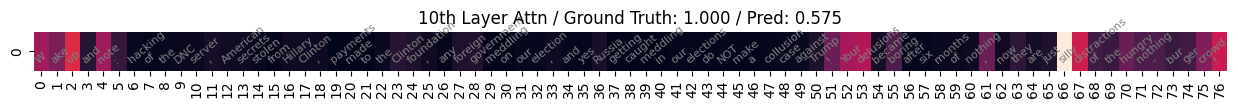

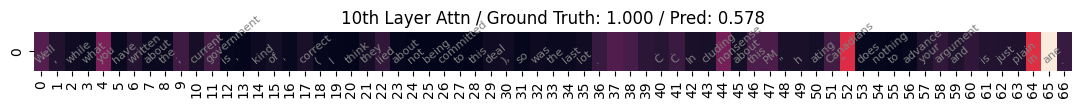

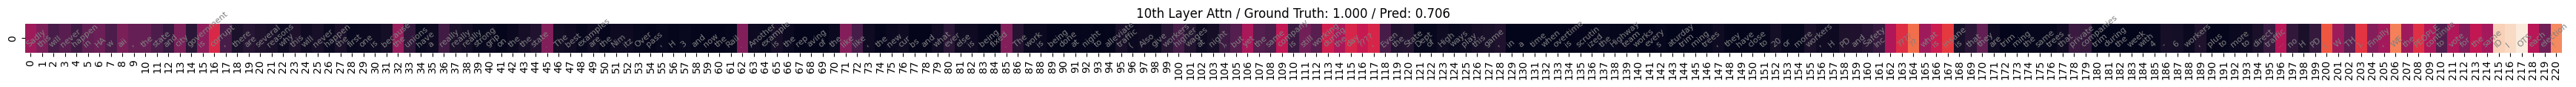

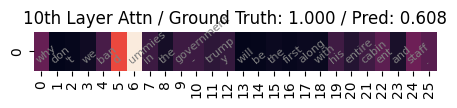

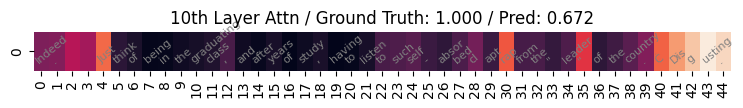

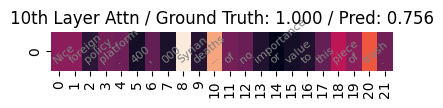

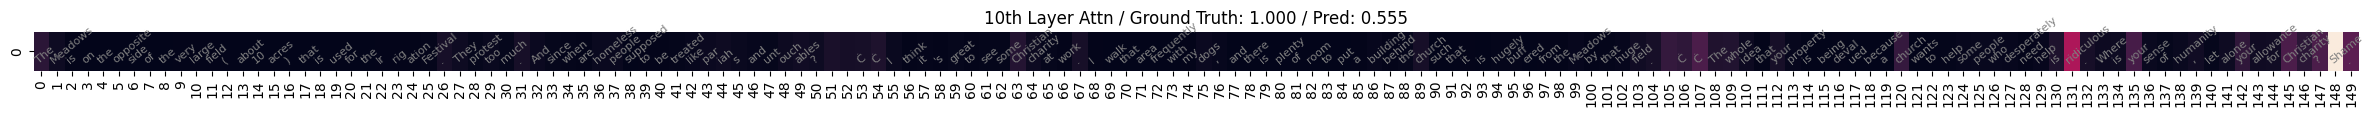

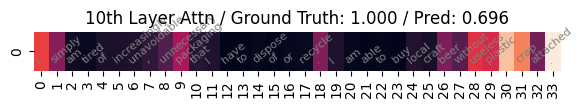

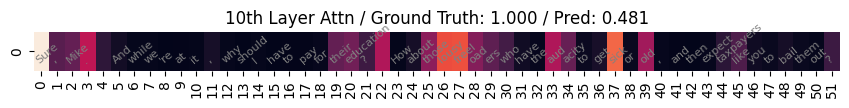

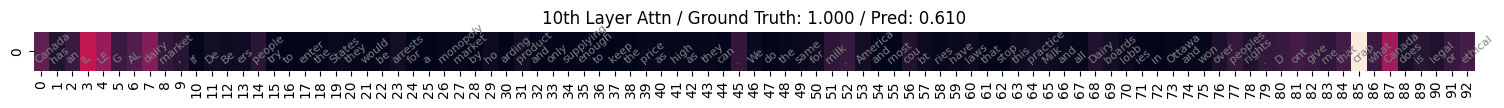

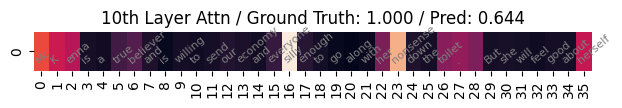

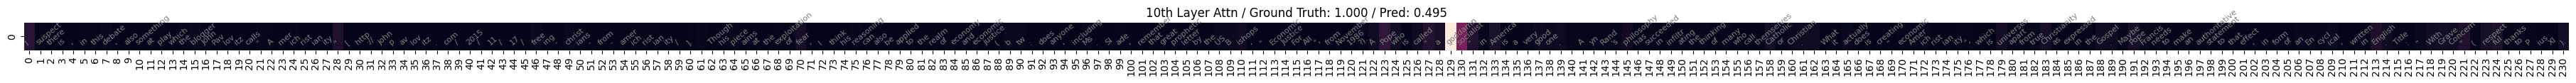

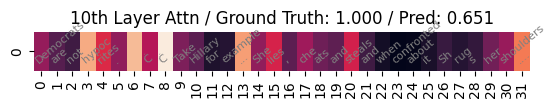

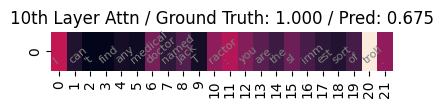

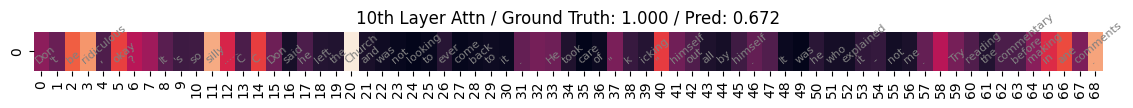

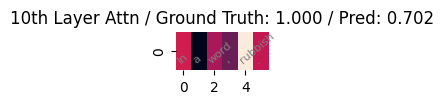

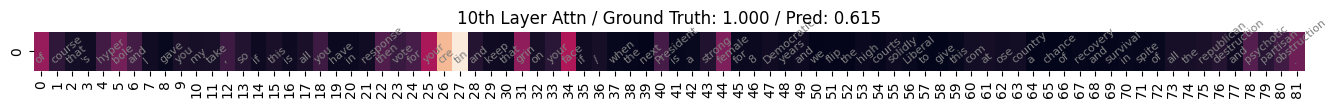

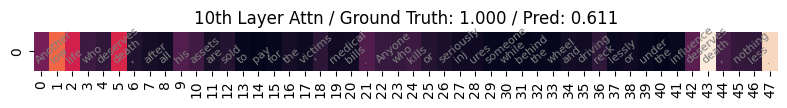

Batch:  1


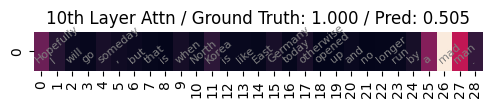

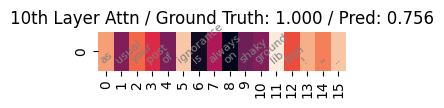

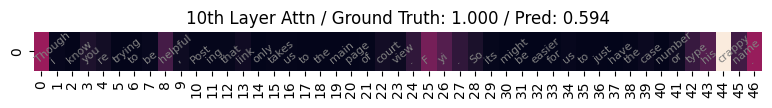

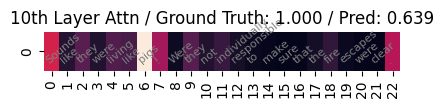

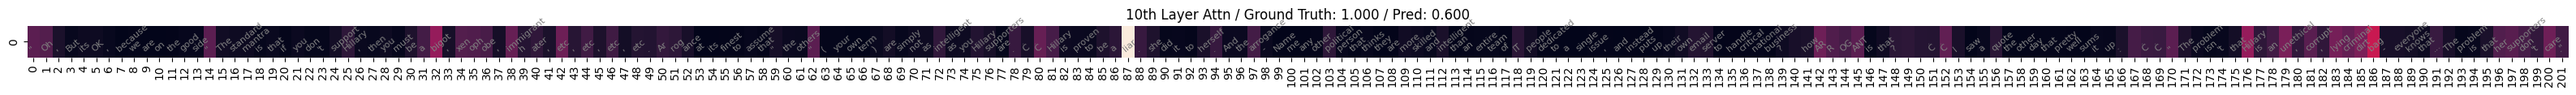

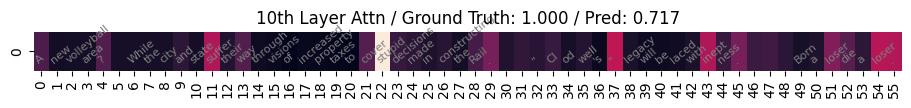

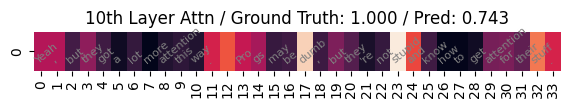

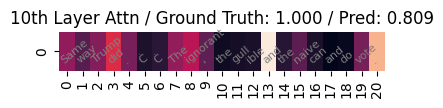

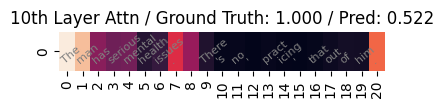

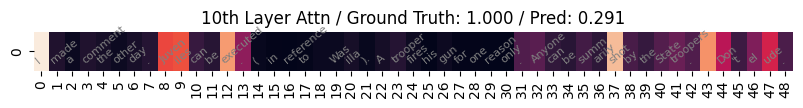

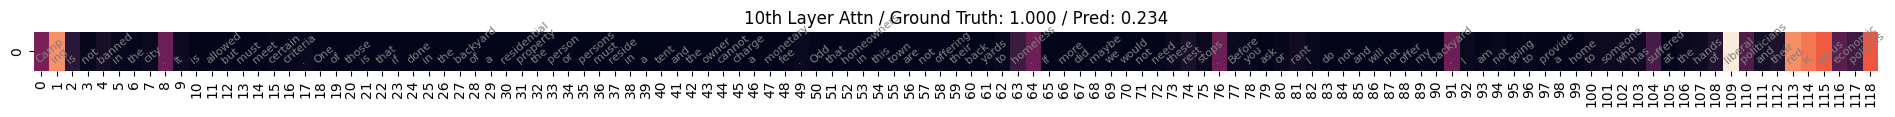

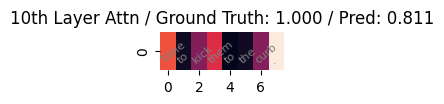

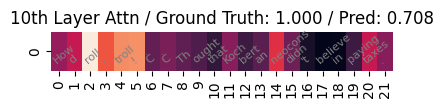

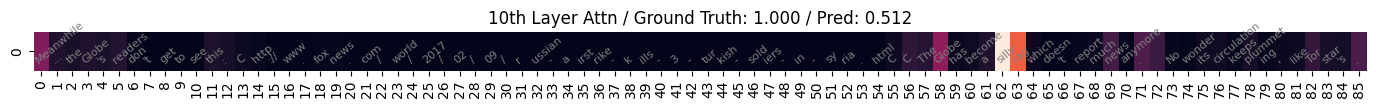

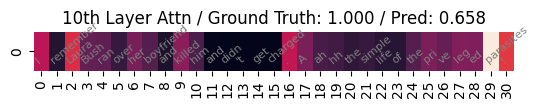

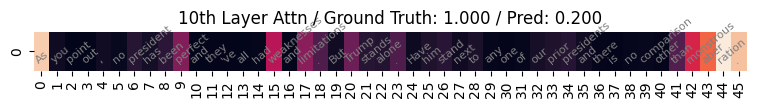

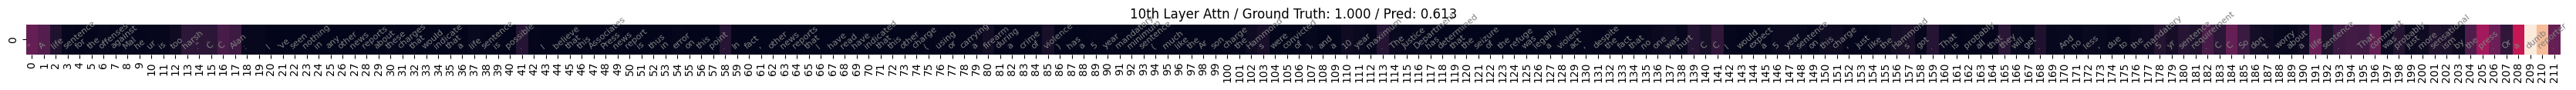

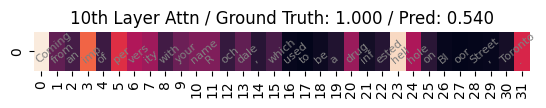

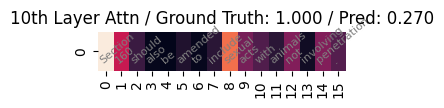

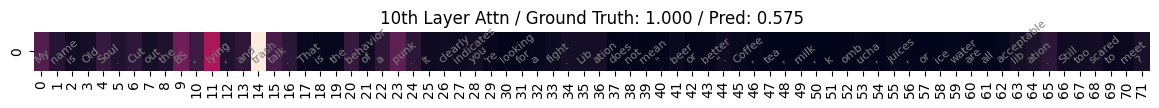

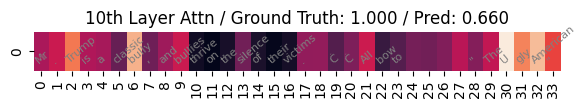

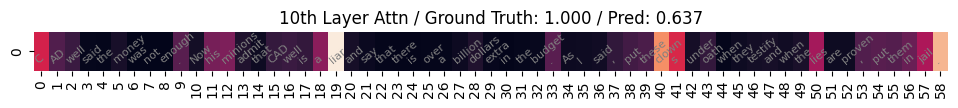

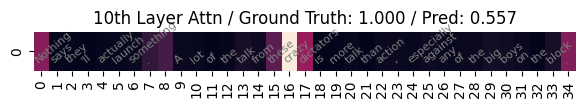

In [13]:
# 알게된 사실 attention value의 절대값은 굉장히 균일하다. -> 상대적으로 분석해야 한다. ㅠ
# 밝을 수록 값이 큰 것
for batch_num in range(len(cls_attns_soft_list)):
    print("Batch: ", batch_num)
    for ix in range(len(cls_attns_soft_list[batch_num])):

        attn=cls_attns_soft_list[batch_num][ix][cls_attns_soft_list[batch_num][ix]!=0.0]
        attn=attn.cpu().unsqueeze(0).numpy()
        toks=tokenizer.convert_ids_to_tokens(input_id_list[batch_num][ix][input_id_list[batch_num][ix]!=50256])
        toks=[x.strip('Ġ') for x in toks]

        fig = plt.figure(figsize=(0.2 * len(toks), 0.5))
        # sns.heatmap(attn, cbar=False,vmin=0, vmax=1)
        sns.heatmap(attn, cbar=False)
        for _x in range(attn.shape[-1]):
            plt.text(_x, 0.8, toks[_x], size=8, color='gray', rotation=40)
        plt.title(f"{layer_num}th Layer Attn / Ground Truth: {labels_list[batch_num][ix]:.3f} / Pred: {preds_list[batch_num][ix]:.3f}")
        plt.savefig(f"./notebooks/XAI/fig/layer{layer_num}_gt{labels_list[batch_num][ix]:.3f}_ix{ix+32*batch_num}_pred{preds_list[batch_num][ix]:.3f}.png",bbox_inches="tight")
        plt.show()